In [1]:
import matplotlib

import draft_mainmodule as mainmod
import load_plot_save as load
import draft_mantle_timestepping_2 as mantle_timestepping
import draft_analysis as analysis
import draft_core_functions_2
import draft_mantle_properties as mantle_properties

%matplotlib inline

In [2]:
load.make_default_param_file()

(run_ID, folder, timestep, r_planet, core_size_factor,
reg_fraction, max_time, temp_core_melting, olivine_cp,
olivine_density, cmb_conductivity, core_cp, core_density,
temp_init, temp_surface, core_temp_init, core_latent_heat,
kappa_reg, dr, cond_constant, density_constant,
heat_cap_constant) = load.load_params_from_file()

# replacing default folder with local path
folder = '/home/maeve/Documents/quick_example_pytesimal'

In [3]:
load.check_folder_exists(folder)

In [4]:
(r_core,
radii,
core_radii,
reg_thickness,
where_regolith,
times,
mantle_temperature_array,
core_temperature_array) = mainmod.set_up()

latent = []

In [5]:
core_values = draft_core_functions_2.IsothermalEutecticCore(temp=core_temp_init, melt=temp_core_melting,
                                                            outer_r=r_core, inner_r=0, rho=core_density, cp=core_cp,
                                                            core_latent_heat=core_latent_heat)

In [6]:
(mantle_conductivity, mantle_heatcap, mantle_density) = mantle_properties.set_up_mantle_properties()


In [7]:
top_mantle_bc = mantle_timestepping.surface_dirichlet_bc
bottom_mantle_bc = mantle_timestepping.cmb_dirichlet_bc

In [8]:
(mantle_temperature_array,
core_temperature_array,
latent,
)= mantle_timestepping.discretisation(
    core_values,
    latent,
    temp_init,
    core_temp_init,
    top_mantle_bc,
    bottom_mantle_bc,
    temp_surface,
    mantle_temperature_array,
    dr,
    core_temperature_array,
    timestep,
    r_core,
    radii,
    times,
    where_regolith,
    kappa_reg,
    mantle_conductivity,
    mantle_heatcap,
    mantle_density)


In [9]:
mantle_temperature_array

array([[1600.        , 1600.        , 1600.        , ...,  758.71128667,
         758.70521728,  758.69914797],
       [1600.        , 1600.        , 1600.        , ...,  753.12239255,
         753.1163917 ,  753.11039093],
       [1600.        , 1600.        , 1600.        , ...,  747.56721019,
         747.56127747,  747.55534483],
       ...,
       [1600.        , 1600.        , 1600.        , ...,  255.79546785,
         255.7954021 ,  255.79533636],
       [1600.        , 1600.        , 1593.22278226, ...,  252.88932606,
         252.88929329,  252.88926053],
       [1600.        ,  250.        ,  250.        , ...,  250.        ,
         250.        ,  250.        ]])

In [10]:
(core_frozen,
 times_frozen,
 time_core_frozen,
 fully_frozen) = analysis.core_freezing(core_temperature_array,
                                        max_time,
                                        times,
                                        latent,
                                        temp_core_melting,
                                        timestep)


core_frozen: [array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])]; times_frozen: [ 54111  54112  54113 ... 126226 126227 126228]; time_core_frozen: 5411100000000000.0; fully_frozen: 7637200000000000.0


In [11]:
dT_by_dt = analysis.cooling_rate(mantle_temperature_array, timestep)
dT_by_dt_core = analysis.cooling_rate(core_temperature_array, timestep)

In [12]:
mantle_cooling_rates = dT_by_dt
core_cooling_rates = dT_by_dt_core

In [13]:
d_im = 147  # cz diameter in nm
d_esq = 158  # cz diameter in nm

In [14]:
imilac_cooling_rate = analysis.cooling_rate_to_seconds(
    analysis.cooling_rate_cloudyzone_diameter(d_im))
esquel_cooling_rate = analysis.cooling_rate_to_seconds(
    analysis.cooling_rate_cloudyzone_diameter(d_esq))

im_depth, im_x, im_time_core_frozen, im_Time_of_Crossing, im_Critical_Radius = analysis.meteorite_depth_and_timing(
    imilac_cooling_rate,
    mantle_temperature_array,
    dT_by_dt,
    radii,
    r_planet,
    core_size_factor,
    time_core_frozen,
    fully_frozen,
    dr=1000,
)

esq_depth, esq_x, esq_time_core_frozen, esq_Time_of_Crossing, esq_Critical_Radius = analysis.meteorite_depth_and_timing(
    esquel_cooling_rate,
    mantle_temperature_array,
    dT_by_dt,
    radii,
    r_planet,
    core_size_factor,
    time_core_frozen,
    fully_frozen,
    dr=1000,
)

meteorite_results_dict = { 'Esq results':
                               {'depth': esq_depth,
                                'text result': esq_x},
                           'Im results':
                               {'depth' : im_depth,
                                'text result': im_x,
                                'critical radius': im_Critical_Radius}}

In [15]:
print(f"Imilac depth: {im_depth}; Imilac timing: {im_x}")
print(f"Esquel depth: {esq_depth}; Esquel timing: {esq_x}")

Imilac depth: 57.0; Imilac timing: Core has started solidifying
Esquel depth: 64.0; Esquel timing: Core has started solidifying


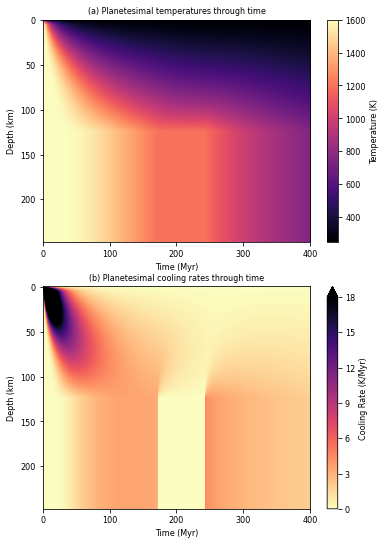

In [16]:
fig_w = 6
fig_h = 9

load.two_in_one(
    fig_w,
    fig_h,
    mantle_temperature_array,
    core_temperature_array,
    dT_by_dt,
    dT_by_dt_core,)

In [17]:
result_filename = 'example_results1'
load.save_params_and_results(result_filename, run_ID, folder, timestep, r_planet, core_size_factor,
                        reg_fraction, max_time, temp_core_melting, olivine_cp,
                        olivine_density, cmb_conductivity, core_cp, core_density,
                        temp_init, temp_surface, core_temp_init, core_latent_heat,
                        kappa_reg, dr, cond_constant, density_constant,
                        heat_cap_constant, time_core_frozen, fully_frozen,
                        meteorite_results=meteorite_results_dict)


In [18]:
load.save_result_arrays(result_filename,
                       folder,
                       mantle_temperature_array,
                       core_temperature_array,
                       mantle_cooling_rates,
                       core_cooling_rates)
